In [1]:
# reload packages
%load_ext autoreload
%autoreload 2

### Choose GPU (this may not be needed on your computer)

In [2]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=0


In [ ]:
import tensorflow as tf
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpu_devices[0], True)

### load packages

In [3]:
from tfumap.umap import tfUMAP

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [4]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
import umap
import pandas as pd

In [5]:
from tfumap.umap import tfUMAP

### Load dataset

In [6]:
from tfumap.paths import ensure_dir, MODEL_DIR, DATA_DIR

In [7]:
#dataset_address = 'http://file.biolab.si/opentsne/macosko_2015.pkl.gz'
# https://opentsne.readthedocs.io/en/latest/examples/01_simple_usage/01_simple_usage.html
# also see https://github.com/berenslab/rna-seq-tsne/blob/master/umi-datasets.ipynb

In [8]:
import gzip
import pickle

with gzip.open(DATA_DIR / 'macosko_2015.pkl.gz', "rb") as f:
    data = pickle.load(f)

x = data["pca_50"]
y = data["CellType1"].astype(str)

In [9]:
np.max(x)

262.05159275199077

In [10]:
np.min(x)

-122.13919378040126

In [11]:
np.shape(x)

(44808, 50)

In [12]:
def zero_one_norm(x):
    return (x- np.min(x, axis=0))/ (np.max(x, axis=0)-np.min(x, axis=0))

In [13]:
x_norm = zero_one_norm(x)

In [14]:
np.max(x_norm[:,0])

1.0

In [15]:
print("Data set contains %d samples with %d features" % x.shape)

Data set contains 44808 samples with 50 features


In [16]:
from sklearn.model_selection import train_test_split

In [17]:
X_train, X_test, Y_train, Y_test = train_test_split(x_norm, y, test_size=.1, random_state=42)

In [18]:
np.shape(X_train)

(40327, 50)

In [19]:
n_valid = 10000
X_valid = X_train[-n_valid:]
Y_valid = Y_train[-n_valid:]
X_train = X_train[:-n_valid]
Y_train = Y_train[:-n_valid]

In [20]:
X_train_flat = X_train

In [21]:
from sklearn.preprocessing import OrdinalEncoder
enc = OrdinalEncoder()

In [22]:
Y_train = enc.fit_transform([[i] for i in Y_train]).flatten()

### Create model and train

In [23]:
embedder = tfUMAP(
    n_components= 64,
    direct_embedding=False,
    verbose=True,
    negative_sample_rate=5,
    training_epochs=5,
    decoding_method='network'
    #encoder=encoder,
    #dims = dims,
)

In [24]:
z = embedder.fit_transform(X_train_flat)

tfUMAP(decoding_method='autoencoder', negative_sample_rate=5,
       optimizer=<tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7f88e3f0e940>,
       tensorboard_logdir='/tmp/tensorboard/20200714-111920',
       training_epochs=5)
Construct fuzzy simplicial set
Tue Jul 14 11:19:21 2020 Finding Nearest Neighbors
Tue Jul 14 11:19:21 2020 Building RP forest with 14 trees
Tue Jul 14 11:19:23 2020 parallel NN descent for 15 iterations
	 0  /  15
	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	 5  /  15
Tue Jul 14 11:19:39 2020 Finished Nearest Neighbor Search
Tue Jul 14 11:19:46 2020 Embedding with TensorFlow


Tue Jul 14 11:24:24 2020 Finished embedding


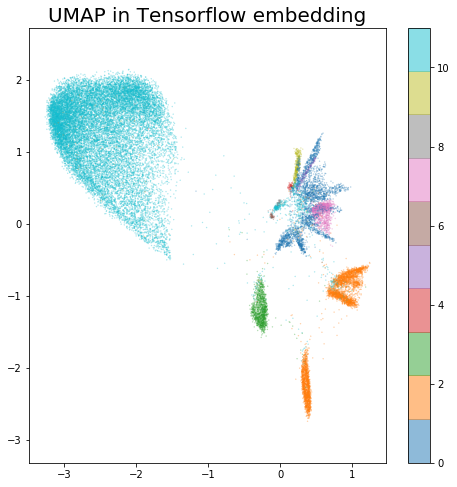

In [25]:
fig, ax = plt.subplots( figsize=(8, 8))
sc = ax.scatter(
    z[:, 0],
    z[:, 1],
    c=Y_train,
    cmap="tab10",
    s=0.1,
    alpha=0.5,
    rasterized=True,
)
ax.axis('equal')
ax.set_title("UMAP in Tensorflow embedding", fontsize=20)
plt.colorbar(sc, ax=ax);

### View loss

In [26]:
from tfumap.umap import retrieve_tensors
import seaborn as sns

In [27]:
loss_df = retrieve_tensors(embedder.tensorboard_logdir)
loss_df[:3]

['umap_loss', 'recon_loss']
[]


,wall_time,step,val,group,variable
0,1.594751e+09,1,3.933800,train,umap_loss
1,1.594751e+09,2,3.821568,train,umap_loss
2,1.594751e+09,3,3.757868,train,umap_loss


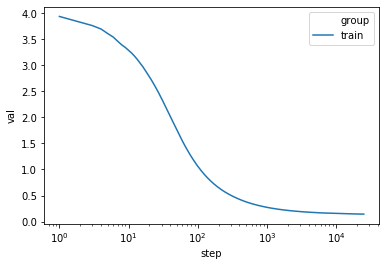

In [28]:
ax = sns.lineplot(x="step", y="val", hue="group", data=loss_df[loss_df.variable=='umap_loss'])
ax.set_xscale('log')

### Save output

In [29]:
from tfumap.paths import ensure_dir, MODEL_DIR

In [30]:
output_dir = MODEL_DIR/'projections'/ 'macosko2015' / '64'/ 'recon-network'
ensure_dir(output_dir)

In [31]:
embedder.save(output_dir)

Pickle of model saved


W0714 11:24:45.647367 140228939540224 deprecation.py:506] From /mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tensorflow_core/python/ops/resource_variable_ops.py:1786: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
I0714 11:24:45.782697 140228939540224 builder_impl.py:775] Assets written to: /mnt/cube/tsainbur/Projects/github_repos/umap_tf_networks/models/projections/macosko2015/64/autoencoder/encoder/assets


Encoder Keras model saved


I0714 11:24:46.550384 140228939540224 builder_impl.py:775] Assets written to: /mnt/cube/tsainbur/Projects/github_repos/umap_tf_networks/models/projections/macosko2015/64/autoencoder/decoder/assets


Decoder Keras model saved


In [32]:
loss_df.to_pickle(output_dir / 'loss_df.pickle')

In [33]:
np.save(output_dir / 'z.npy', z)